In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import sys
import time

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100


In [3]:
def is_season_day(m, d):
    '''
    Returns True if the given date is both in `year` and is in the
    defined (May 10-Oct 20) growing season.
    '''
    return ((m == 5) & (d >= 10)) | ((m >= 6) & (m <= 9)) | ((m == 10) & (d <= 20))

monlen = [0,31,28,31,30,31,30,31,31,30,31,30,31]

season_days = []
for m in range(1,13):
    for d in range(1, monlen[m] + 1):
        if is_season_day(m, d):
            season_days += [(m, d)]

In [4]:
def sample_5cd(data, month, day, year0, yearn):
    '''
    Return the 5CD slice (5 contiuous days centered around the given date,
    over the base period) for the given calendar day.
    '''
    agg = []
    for year in range(year0, yearn):
        center = data[(data.YEAR == year) & (data.MONTH == month) & (data.DAY == day)].index[0]
        agg.append(data.loc[int(center-2):int(center+2)])
    return pd.concat(agg)

In [5]:
def streak(lst):
    '''
    Returns the longest contiguous streak of truthy values in `lst`
    '''
    best = 0
    count = 0

    for v in lst:
        if v:
            count += 1
            best = max(best, count)
        else:
            count = 0

    return best

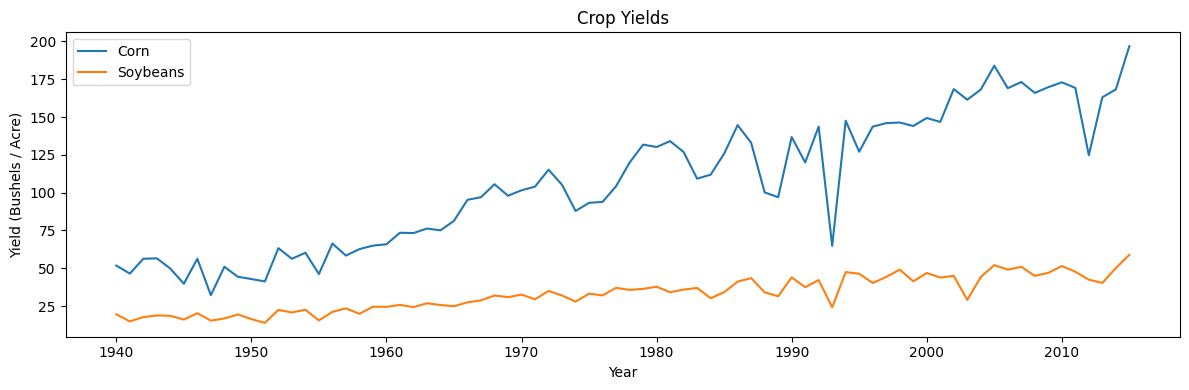

Help on method corr in module pandas.core.frame:

corr(method='pearson', min_periods=1) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Compute pairwise correlation of columns, excluding NA/null values.
    
    Parameters
    ----------
    method : {'pearson', 'kendall', 'spearman'} or callable
        Method of correlation:
    
        * pearson : standard correlation coefficient
        * kendall : Kendall Tau correlation coefficient
        * spearman : Spearman rank correlation
        * callable: callable with input two 1d ndarrays
            and returning a float. Note that the returned matrix from corr
            will have 1 along the diagonals and will be symmetric
            regardless of the callable's behavior.
    
            .. versionadded:: 0.24.0
    
    min_periods : int, optional
        Minimum number of observations required per pair of columns
        to have a valid result. Currently only available for Pearson
        and Spearman correla

In [24]:
ag = pd.read_csv('../data/agri/frontiers/Processed_Iowa+Cerro+Gordo_1960+2009_Annual+Crop.csv')
ag = ag.sort_values('Year')
corn = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'CORN')].copy()
beans = ag.loc[(ag['Data Item'].str.contains('BU / ACRE')) & (ag['Commodity'] == 'SOYBEANS')].copy()
corn['YEAR'] = corn.Year
corn['YIELD'] = corn.Value.astype('float')
corn = corn[['YEAR', 'YIELD']]
beans['YEAR'] = beans.Year
beans['YIELD'] = beans.Value.astype('float')
beans = beans[['YEAR', 'YIELD']]
plt.plot(corn.YEAR, corn.YIELD, label='Corn')
plt.plot(beans.YEAR, beans.YIELD, label='Soybeans') 
ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Yield (Bushels / Acre)')
ax.set_title('Crop Yields')
ax.legend()
plt.gcf().tight_layout()
plt.savefig('yields.png')
plt.show()
corn.corr()

In [7]:
data = ['USC00135230.csv', 'USC00137572.csv', 'USW00014940.csv']
dataroot = '../data/wx/ghcnd'
data = map(lambda x: path.join(dataroot, x), data)
data = [pd.read_csv(d, low_memory=False) for d in data]

prcp = [df[['DATE', 'PRCP']] for df in data]

prcpdf = prcp[0].merge(prcp[1], on='DATE', how='outer')
prcpdf = prcpdf.merge(prcp[2], on='DATE', how='outer')

prcpdf['PRCP'] = prcpdf[['PRCP_x', 'PRCP_y', 'PRCP']].mean(axis = 1)
prcpdf.PRCP = prcpdf.PRCP * 0.1
prcpdf = prcpdf.drop(['PRCP_x', 'PRCP_y'], axis=1)

prcpdf.DATE = pd.to_datetime(prcpdf.DATE)
prcpdf.sort_values('DATE', inplace=True)
prcpdf['YEAR'] = prcpdf.DATE.map(lambda d: d.year)
prcpdf['MONTH'] = prcpdf.DATE.map(lambda d: d.month)
prcpdf['DAY'] = prcpdf.DATE.map(lambda d: d.day)
prcpdf = prcpdf[(prcpdf.YEAR >= 1941) & (prcpdf.YEAR <= 2015)]
prcpseasdf = prcpdf.loc[is_season_day(prcpdf.MONTH, prcpdf.DAY)].copy()
prcpseasdf

,DATE,PRCP,YEAR,MONTH,DAY
16206,1941-05-10,0.0,1941,5,10
16207,1941-05-11,0.0,1941,5,11
16208,1941-05-12,0.0,1941,5,12
16209,1941-05-13,0.0,1941,5,13
16210,1941-05-14,0.0,1941,5,14
...,...,...,...,...,...
42902,2015-10-16,0.0,2015,10,16
42903,2015-10-17,0.0,2015,10,17
42904,2015-10-18,0.0,2015,10,18
42905,2015-10-19,0.0,2015,10,19


In [8]:
temp = [df[['DATE', 'TMIN', 'TMAX']] for df in [data[0], data[2]]]

tempdf = temp[0].merge(temp[1], on='DATE', how='outer')

tempdf['TMIN'] = tempdf[['TMIN_x', 'TMIN_y']].mean(axis = 1)
tempdf['TMAX'] = tempdf[['TMAX_x', 'TMAX_y']].mean(axis = 1)
tempdf.TMIN = tempdf.TMIN * 0.1
tempdf.TMAX = tempdf.TMAX * 0.1
tempdf = tempdf.drop(['TMIN_x', 'TMIN_y', 'TMAX_x', 'TMAX_y'], axis=1)

tempdf.DATE = pd.to_datetime(tempdf.DATE)
tempdf.sort_values('DATE', inplace=True)
tempdf['YEAR'] = tempdf.DATE.map(lambda d: d.year)
tempdf['MONTH'] = tempdf.DATE.map(lambda d: d.month)
tempdf['DAY'] = tempdf.DATE.map(lambda d: d.day)
tempdf = tempdf[(tempdf.YEAR >= 1941) & (tempdf.YEAR <= 2015)]
tempseasdf = tempdf.loc[is_season_day(tempdf.MONTH, tempdf.DAY)].copy()
tempseasdf

,DATE,TMIN,TMAX,YEAR,MONTH,DAY
16206,1941-05-10,1.10,18.90,1941,5,10
16207,1941-05-11,5.00,19.40,1941,5,11
16208,1941-05-12,2.20,23.30,1941,5,12
16209,1941-05-13,6.70,26.10,1941,5,13
16210,1941-05-14,18.90,29.40,1941,5,14
...,...,...,...,...,...,...
42902,2015-10-16,0.05,13.05,2015,10,16
42903,2015-10-17,-3.80,11.10,2015,10,17
42904,2015-10-18,-1.90,15.00,2015,10,18
42905,2015-10-19,6.95,20.85,2015,10,19


In [9]:
verf = pd.read_csv('../data/wx/mason_6_2010.csv')
def f_to_c(f):
    return (f - 32) * 5 / 9

def in_to_mm(inch):
    return inch * 25.4

verf.LOW = verf.LOW.map(f_to_c)
verf.HIGH = verf.HIGH.map(f_to_c)
verf.NLOW = verf.NLOW.map(f_to_c)
verf.NHIGH = verf.NHIGH.map(f_to_c)
verf.RECLOW = verf.RECLOW.map(f_to_c)
verf.RECHIGH = verf.RECHIGH.map(f_to_c)

verf.PRCP = verf.PRCP.map(in_to_mm)
verf.RECPRCP = verf.RECPRCP.map(in_to_mm)

tt = tempdf[(tempdf.YEAR == 2010) & (tempdf.MONTH == 6)]
plt.plot(range(1,31), verf.LOW, label='Mason City Low')
plt.plot(range(1,31), tt.TMIN, label='Cerrado Low')
plt.plot(range(1,31), verf.HIGH, label='Mason City High')
plt.plot(range(1,31), tt.TMAX, label='Cerrado High')
plt.legend()
plt.show()

pp = prcpdf[(prcpdf.YEAR == 2010) & (prcpdf.MONTH == 6)]
plt.plot(range(1,31), verf.PRCP, label='Mason City')
plt.plot(range(1,31), pp.PRCP, label='Cerrado')
plt.legend()
plt.show()
verf['DAY'] = verf.ID
tt.merge(verf, on='DAY')[['DAY', 'TMAX', 'HIGH']]

FileNotFoundError: [Errno 2] No such file or directory: '../data/wx/mason_6_2010.csv'

In [10]:
'''
GSP
'''
GSP = prcpseasdf[['YEAR', 'PRCP']].groupby('YEAR').agg(np.mean)

In [11]:
'''
GDD
'''
GDD = tempseasdf.copy()
GDD['GDD'] = (GDD.TMAX + GDD.TMIN) * 0.5 - 10.0
GDD = GDD[['YEAR', 'GDD']].groupby('YEAR').agg(sum)

In [12]:
'''
GSTmax
GSTmin
'''
GSTmax = tempseasdf[['YEAR', 'TMAX']].groupby('YEAR').agg(np.mean)
GSTmin = tempseasdf[['YEAR', 'TMIN']].groupby('YEAR').agg(np.mean)


In [31]:
'''
frost
'''
tempseasdf['FROSTY'] = tempseasdf.TMIN < 0
frost = tempseasdf[['YEAR', 'FROSTY']].groupby('YEAR').agg(sum)

In [14]:
'''
summer
'''
tempseasdf['SUMMER'] = tempseasdf.TMAX > 25
summer = tempseasdf[['YEAR', 'SUMMER']].groupby('YEAR').agg(sum)
summer

,SUMMER
YEAR,
1941,94
1942,81
1943,80
1944,91
1945,66
...,...
2011,92
2012,107
2013,82


In [50]:
'''
CWI/HWI
'''

def true_streaks(l):
    count = 0
    val = l[0]
    streaks = []
    for v in l:
        if val == v:
            count += 1
        else:
            if val:
                streaks.append(count)
            val = v
            count = 1
    if val:
        streaks.append(count)
    return streaks

def sixcount(st):
    st = [x for x in st if x >= 6]
    return sum(st)

def con(l):
    return sixcount(true_streaks(l))

t = time.time()
tmax90 = []
tmin10 = []
s5cd = {}
for (m, d) in season_days:
    s = sample_5cd(tempdf, m, d, 1961, 1991)
    s5cd[m*32+d] = s
    tmax90.append(s.TMAX.quantile(0.9))
    tmin10.append(s.TMIN.quantile(0.1))
    
hwi = []
hwibiased = []
cwi = []
cwibiased = []
for year in range(1941, 2016):
    print(year, time.time() - t)
    tmax = tempseasdf[tempseasdf.YEAR == year].TMAX
    tmin = tempseasdf[tempseasdf.YEAR == year].TMIN
    if year < 1961 or year > 1990:
        toohot = [x > y for (x,y) in zip(tmax, tmax90)]
        hwi.append(con(toohot))
        hwibiased.append(con(toohot))
        toocold = [x < y for (x,y) in zip(tmin, tmin10)]
        cwi.append(con(toocold))
        cwibiased.append(con(toocold))
    else:
        tminboot = []
        tmaxboot = []
        for repl in range(1961, 1991):
            if repl == year:
                continue
            retmax90 = []
            retmin10 = []
            for (m, d) in season_days:
                base = s5cd[m*32+d]
                base = base[base.YEAR != year]
                resampled = base.append(base[base.YEAR == repl])
                retmax90.append(resampled.TMAX.quantile(0.9))
                retmin10.append(resampled.TMIN.quantile(0.1))
            retmax = con([x > y for (x,y) in zip(tmax, retmax90)])
            retmin = con([x < y for (x,y) in zip(tmin, retmin10)])
            tmaxboot.append(retmax)
            tminboot.append(retmin)
        hwi.append(np.mean(tmaxboot))
        cwi.append(np.mean(tminboot))
        toohot = [x > y for (x,y) in zip(tmax, tmax90)]
        hwibiased.append(con(toohot))
        toocold = [x < y for (x,y) in zip(tmin, tmin10)]
        cwibiased.append(con(toocold))
            
HWI = pd.DataFrame({'HWI': hwi}, range(1941, 2016))
CWI = pd.DataFrame({'CWI': cwi}, range(1941, 2016))

print(time.time()-t)

1941 6.085644960403442
1942 6.087951183319092
1943 6.090106725692749
1944 6.092284917831421
1945 6.094435214996338
1946 6.096561670303345
1947 6.098690986633301
1948 6.100797653198242
1949 6.10293436050415
1950 6.105049133300781
1951 6.107182741165161
1952 6.109318733215332
1953 6.111432075500488
1954 6.113551139831543
1955 6.115669012069702
1956 6.117788553237915
1957 6.119904279708862
1958 6.12204384803772
1959 6.124159574508667
1960 6.126274347305298
1961 6.128402233123779
1962 19.99363112449646
1963 33.94280505180359
1964 48.35160231590271
1965 62.46159029006958
1966 76.6109459400177
1967 90.76125907897949
1968 104.92529630661011
1969 119.03315234184265
1970 133.11604166030884
1971 147.4652237892151
1972 161.50944566726685
1973 175.48430919647217
1974 189.67406010627747
1975 203.8557744026184
1976 218.25246286392212
1977 232.66924715042114
1978 246.93474674224854
1979 261.1328830718994
1980 275.32055854797363
1981 289.5630965232849
1982 303.73531699180603
1983 317.7752757072449
198

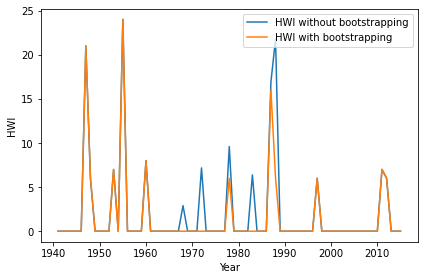

In [60]:
HWIBiased = pd.DataFrame({'HWI': hwibiased}, range(1941, 2016))
CWIBiased = pd.DataFrame({'CWI': cwibiased}, range(1941, 2016))


#plt.plot(CWI.index, CWI.CWI)
#plt.plot(CWIBiased.index, CWIBiased.CWI)

plt.plot(HWI.index, HWI.HWI, label="HWI without bootstrapping")
plt.plot(HWIBiased.index, HWIBiased.HWI, label="HWI with bootstrapping")
plt.legend()
ax = plt.gca()
ax.set_xlabel("Year")
ax.set_ylabel("HWI")
plt.tight_layout()
plt.savefig("hwi-boost.png")
plt.show()


In [17]:
'''
dry/wet
'''
prcpseasdf['DRY'] = prcpseasdf.PRCP < 1 
prcpseasdf['WET'] = prcpseasdf.PRCP >= 1
dry = prcpseasdf[['YEAR', 'DRY']].groupby('YEAR').agg(lambda s: streak(s))
wet = prcpseasdf[['YEAR', 'WET']].groupby('YEAR').agg(lambda s: streak(s))

In [27]:
'''
PRCP95P
''' 
wet_days = prcpseasdf[(prcpseasdf.YEAR >= 1961) & (prcpseasdf.YEAR < 1991) & (prcpseasdf.PRCP >= 1)]
RRwn95 = wet_days.PRCP.quantile(0.95)
PRCP95P = prcpseasdf[['YEAR', 'PRCP']].groupby('YEAR').agg(lambda x: x[x > RRwn95].count())


In [29]:
'''
Tropical nights
'''
tempseasdf['TROPICAL'] = tempseasdf.TMIN > 20
tropical = tempseasdf[['YEAR', 'TROPICAL']].groupby('YEAR').agg(sum)

,TROPICAL
YEAR,
1941,11
1942,9
1943,12
1944,7
1945,6
...,...
2011,13
2012,9
2013,9


In [59]:
df = pd.DataFrame({
    'YEAR': range(1941, 2016), 
    'GSP': GSP.PRCP, 
    'GDD': GDD.GDD, 
    'GSTmin': GSTmin.TMIN, 
    'GSTmax': GSTmax.TMAX, 
    'frost': frost.FROSTY,
    'summer': summer.SUMMER,
    'HWI': HWI.HWI,
    'CWI': CWI.CWI,
    'dry': dry.DRY,
    'wet': wet.WET,
    'PRCP95P': PRCP95P.PRCP,
    'TROPICAL': tropical.TROPICAL
})
df.to_csv('../data/wx/wx-frontier-agg-3.csv')

<AxesSubplot:>

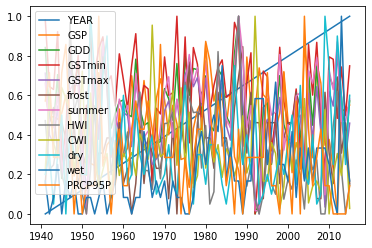

In [23]:
normalized_df=(df-df.min())/(df.max()-df.min())

normalized_df.plot()


In [26]:
tempseasdf[tempseasdf.TMIN >= 20]

,DATE,TMIN,TMAX,YEAR,MONTH,DAY,FROSTY,SUMMER
16279,1941-07-22,20.00,34.40,1941,7,22,False,True
16280,1941-07-23,21.70,34.40,1941,7,23,False,True
16281,1941-07-24,21.70,37.20,1941,7,24,False,True
16283,1941-07-26,20.60,32.20,1941,7,26,False,True
16284,1941-07-27,20.00,32.20,1941,7,27,False,True
...,...,...,...,...,...,...,...,...
42484,2014-08-24,20.30,30.00,2014,8,24,False,True
42807,2015-07-13,21.10,32.25,2015,7,13,False,True
42821,2015-07-27,20.85,27.25,2015,7,27,False,True
42861,2015-09-05,20.00,31.40,2015,9,5,False,True
